# Image classification with convolutional neural networks!

This is my implementation of lession 1 of the fast.ai deep learning course.

For learning purposes I will write from scratch all the steps explained in the lesson and use a different dataset from the one proposed (dogs vs cats).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/cars/'
sz = 224

In [4]:
print (torch.cuda.is_available())
print (torch.backends.cudnn.enabled)

True
True


In [5]:
os.listdir(PATH)

['models',
 'tmp',
 'bmw10_annos.mat',
 'devkit',
 'bmw10_ims',
 'cars_test',
 'cars_train']

In [6]:
annotations = os.listdir(f'{PATH}devkit/')
annotations

['eval_train.m',
 'cars_test_annos.mat',
 'cars_train_annos.mat',
 'train_perfect_preds.txt',
 'README.txt',
 'cars_meta.mat']

In [7]:
from scipy.io import loadmat

classes = loadmat(f'{PATH}devkit/{annotations[5]}')
# classes

In [8]:
print ('Number of classes:')
len(classes['class_names'][0])

Number of classes:


196

In [9]:
print('Lets look at the classes')
classes['class_names']

Lets look at the classes


array([[array(['AM General Hummer SUV 2000'], dtype='<U26'), array(['Acura RL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Sedan 2012'], dtype='<U19'), array(['Acura TL Type-S 2008'], dtype='<U20'),
        array(['Acura TSX Sedan 2012'], dtype='<U20'), array(['Acura Integra Type R 2001'], dtype='<U25'),
        array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
        array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
        array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
        array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
        array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
        array(['Audi RS 4 Convertible 2008'], dtype='<U26'), array(['Audi A5 Coupe 2012'], dtype='<U18'),
        array(['Audi TTS Coupe 2012'], dtype='<U19'), array(['Audi R8 Coupe 2012'], dtype='<U18'),
        array(['Audi V8 Sedan 1994'], dtype='<U18'), array(['Audi 100 Sedan 1994'], dtype='<U19'),
        array(['Audi 100 Wagon 1994'], dty

In [10]:
print('I like the Audi TT, so lets find out which id corresponds to that class')
for i,c in enumerate(classes['class_names'][0]):
    if c[0]=='Audi TT RS Coupe 2012':
        print(i)

I like the Audi TT, so lets find out which id corresponds to that class
24


In [13]:
cars_train_annot = loadmat(f'{PATH}devkit/{annotations[2]}')

cars_train_annot['annotations']

array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
        (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
        (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
        ...,
        (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
        (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9')),
        (array([[20]], dtype=uint8

In [15]:
files = os.listdir(f'{PATH}cars_train')
files[:5]

['00300.jpg', '07630.jpg', '00350.jpg', '01529.jpg', '01151.jpg']

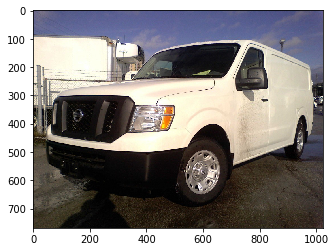

In [16]:
img = plt.imread(f'{PATH}cars_train/{files[0]}')
plt.imshow(img)

In [17]:
img.shape

(768, 1024, 3)

In [18]:
img[:4][:4]

array([[[ 98,  89, 136],
        [101,  92, 137],
        [106,  99, 143],
        ...,
        [ 98,  95, 140],
        [ 98,  95, 140],
        [101, 100, 144]],

       [[106,  97, 142],
        [102,  93, 138],
        [ 99,  92, 134],
        ...,
        [ 99,  96, 141],
        [ 98,  95, 140],
        [101,  98, 143]],

       [[111, 102, 145],
        [105,  96, 139],
        [100,  92, 133],
        ...,
        [ 98,  95, 142],
        [ 97,  94, 139],
        [ 99,  96, 141]],

       [[109, 101, 142],
        [109, 101, 140],
        [108, 100, 139],
        ...,
        [ 96,  93, 140],
        [ 95,  92, 139],
        [ 96,  93, 140]]], dtype=uint8)

In [64]:
print('Lets transform the annotations into a csv file')
data_structs = cars_train_annot['annotations']

train_labels = []
file_names = []
for elem in data_structs[0]:
    file_names.append(elem['fname'])
    train_labels.append(elem['class'])
train_labels = np.asarray(train_labels).flatten()
file_names = np.asarray(file_names).flatten()

class_names = []
for cls in classes['class_names'][0]:
    class_names.append(cls[0])

dictionary = dict([(f,class_names[l-1].replace(' ','_')) for f,l in zip(file_names,train_labels)])

Lets transform the annotations into a csv file


In [65]:
df = pd.DataFrame.from_dict(dictionary,orient='index')
df.head()

,0
00001.jpg,Audi_TTS_Coupe_2012
00002.jpg,Acura_TL_Sedan_2012
00003.jpg,Dodge_Dakota_Club_Cab_2007
00004.jpg,Hyundai_Sonata_Hybrid_Sedan_2012
00005.jpg,Ford_F-450_Super_Duty_Crew_Cab_2012


In [66]:
csv_file_name = PATH+'cars.csv'
df.to_csv(csv_file_name)
df = pd.read_csv(csv_file_name)
df.head()

,Unnamed: 0,0
0,00001.jpg,Audi_TTS_Coupe_2012
1,00002.jpg,Acura_TL_Sedan_2012
2,00003.jpg,Dodge_Dakota_Club_Cab_2007
3,00004.jpg,Hyundai_Sonata_Hybrid_Sedan_2012
4,00005.jpg,Ford_F-450_Super_Duty_Crew_Cab_2012


In [67]:
arch = resnet34
data = ImageClassifierData.from_csv(PATH,'cars_train/',csv_file_name,tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch,data, precompute=True)
learn.fit(0.01,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      5.02672    4.155192   0.122236  
    1      4.067341   3.581122   0.214373                   



[array([3.58112]), 0.21437346437346438]

In [68]:
data.val_y

array([ 64,  57, 168, ..., 186,  11, 114])

In [69]:
data.classes

['AM_General_Hummer_SUV_2000',
 'Acura_Integra_Type_R_2001',
 'Acura_RL_Sedan_2012',
 'Acura_TL_Sedan_2012',
 'Acura_TL_Type-S_2008',
 'Acura_TSX_Sedan_2012',
 'Acura_ZDX_Hatchback_2012',
 'Aston_Martin_V8_Vantage_Convertible_2012',
 'Aston_Martin_V8_Vantage_Coupe_2012',
 'Aston_Martin_Virage_Convertible_2012',
 'Aston_Martin_Virage_Coupe_2012',
 'Audi_100_Sedan_1994',
 'Audi_100_Wagon_1994',
 'Audi_A5_Coupe_2012',
 'Audi_R8_Coupe_2012',
 'Audi_RS_4_Convertible_2008',
 'Audi_S4_Sedan_2007',
 'Audi_S4_Sedan_2012',
 'Audi_S5_Convertible_2012',
 'Audi_S5_Coupe_2012',
 'Audi_S6_Sedan_2011',
 'Audi_TTS_Coupe_2012',
 'Audi_TT_Hatchback_2011',
 'Audi_TT_RS_Coupe_2012',
 'Audi_V8_Sedan_1994',
 'BMW_1_Series_Convertible_2012',
 'BMW_1_Series_Coupe_2012',
 'BMW_3_Series_Sedan_2012',
 'BMW_3_Series_Wagon_2012',
 'BMW_6_Series_Convertible_2007',
 'BMW_ActiveHybrid_5_Sedan_2012',
 'BMW_M3_Coupe_2012',
 'BMW_M5_Sedan_2010',
 'BMW_M6_Convertible_2010',
 'BMW_X3_SUV_2012',
 'BMW_X5_SUV_2007',
 'BMW_X6

In [70]:
log_predictions = learn.predict()
log_predictions.shape

(1628, 196)

In [71]:
predictions = np.argmax(log_predictions,axis=1)
probabilities = np.exp(log_predictions[:,24]) #audi TT